# AdaBoost
(by Tevfik Aytekin)

In [3]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from sklearn.ensemble import AdaBoostClassifier


In [47]:
class MyAdaBoostClassifier:
    
    def __init__(self, n_estimators = 50):
        self.models = []
        self.n_estimators = n_estimators
    
    
    def predict(self,X):
        pred = 0
        for (s, a) in self.models:
            pred += a*s.predict(X)
        return np.sign(pred)
    
    def fit(self, X, y):

        # Initialize weights for all instances
        w = np.ones(len(X)) / len(X)
    
        for i in range(self.n_estimators):
            # Fit a classifier with the specific weights. A decision tree whose depth
            # is 1 is called a decision stump
            stump = DecisionTreeClassifier(max_depth = 3)
            
            # fit a tree using weighted gini calculation. It can be also done with 
            # sampling with replacement
            stump.fit(X, y, sample_weight = w)
                        
            X_pred = stump.predict(X)
            
            # Calculate the weighted error of the stump
            miss01 = [int(x) for x in (X_pred != y)]
            error = np.dot(w,miss01)

            # Calculate alpha (the weight of the stump)
            alpha = 0.5 * np.log( (1 - error) / float(error))

            # Calculate the new sample weights
            # Be careful, 1's in miss01 indicate errors.
            miss11 = [x if x==1 else -1 for x in miss01]
            w = np.multiply(w, np.exp([float(x) * alpha for x in miss11]))
            w = w / sum(w) # normalize
            
            self.models.append((stump, alpha))


### Alpha function

In [29]:
def alpha_ada(err_m):
    return 0.5 * np.log( (1 - err_m) / float(err_m))


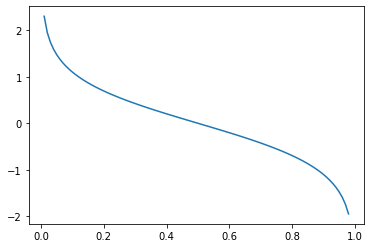

In [30]:
x = np.arange(0.01,.99,0.01)
plt.plot(x, [alpha_ada(i) for i in x])

### Reweighting
for incorrectly predicted samples

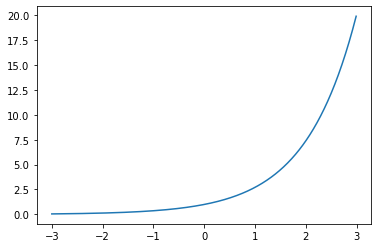

In [31]:
x = np.arange(-3,3,0.01)
plt.plot(x, [np.exp(i) for i in x])

### Reweighting
for correctly predicted samples

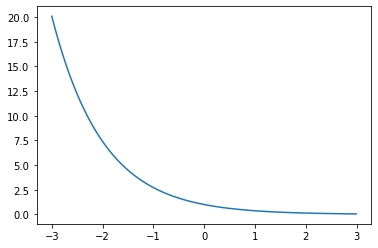

In [32]:
x = np.arange(-3,3,0.01)
plt.plot(x, [np.exp(-i) for i in x])

### Example

In [33]:
w = np.ones(5) / 5
w

array([0.2, 0.2, 0.2, 0.2, 0.2])

In [34]:
X_pred = np.array([1,1,0,1,0])
y = np.array([1,0,0,1,1])

# Calculate the weighted error
miss01 = [int(x) for x in (X_pred != y)]
error = np.dot(w,miss01)
print("X_pred:",X_pred)
print("     y:",y)
print("miss01:",miss01)
print("Error:", error)

X_pred: [1 1 0 1 0]
     y: [1 0 0 1 1]
miss01: [0, 1, 0, 0, 1]
Error: 0.4


In [35]:
# Calculate alpha
alpha = 0.5 * np.log( (1 - error) / float(error))
print("alpha:", alpha)

alpha: 0.2027325540540821


In [36]:
# Calculate the new sample weights
# Be careful, 1's in miss01 indicate errors.
miss11 = [x if x==1 else -1 for x in miss01]
w_1 = np.multiply(w, np.exp([float(x) * alpha for x in miss11]))
w_n = w_1 / sum(w_1) # normalize
print("miss11:",miss11)
print("   w_1:",w_1)
print("   w_n:",w_n)

miss11: [-1, 1, -1, -1, 1]
   w_1: [0.16329932 0.24494897 0.16329932 0.16329932 0.24494897]
   w_n: [0.16666667 0.25       0.16666667 0.16666667 0.25      ]


In [37]:
# Bank Marketing Dataset from
# https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

bank = pd.read_csv("../datasets/bank/bank-full.csv", delimiter = ";")
# print first 5 examples
bank.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [38]:
bank.y.value_counts()

no     39922
yes     5289
Name: y, dtype: int64

In [39]:
bank_majority = bank[bank.y=="no"]
bank_minority = bank[bank.y=="yes"]
 
# downsample
bank_majority_downsampled = resample(bank_majority, 
                                 replace=False,    
                                 n_samples=5289) 
 
bank_balanced = pd.concat([bank_minority, bank_majority_downsampled])
bank_balanced.y.value_counts()

yes    5289
no     5289
Name: y, dtype: int64

In [48]:
X = bank_balanced.loc[:,'age':'poutcome']
y = bank_balanced.loc[:,'y']
# !!!!! You must supply the y values as 1 and -1.
y = y.replace(["yes","no"],[1,-1])
X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_test.mean())
 
clf1 = DecisionTreeClassifier()
clf2 = AdaBoostClassifier(n_estimators=200)
clf3 = MyAdaBoostClassifier(n_estimators=200)

clf1.fit(X_train, y_train);
clf2.fit(X_train, y_train);
clf3.fit(X_train, y_train);

y_pred1 = clf1.predict(X_test)  
y_pred2 = clf2.predict(X_test) 
y_pred3 = clf3.predict(X_test) 

print(classification_report(y_test,y_pred1))
print(classification_report(y_test,y_pred2))
print(classification_report(y_test,y_pred3))

              precision    recall  f1-score   support

          -1       0.78      0.81      0.80       524
           1       0.81      0.78      0.79       534

    accuracy                           0.80      1058
   macro avg       0.80      0.80      0.80      1058
weighted avg       0.80      0.80      0.80      1058

              precision    recall  f1-score   support

          -1       0.82      0.86      0.84       524
           1       0.86      0.81      0.84       534

    accuracy                           0.84      1058
   macro avg       0.84      0.84      0.84      1058
weighted avg       0.84      0.84      0.84      1058

              precision    recall  f1-score   support

          -1       0.87      0.83      0.85       524
           1       0.84      0.88      0.86       534

    accuracy                           0.85      1058
   macro avg       0.86      0.85      0.85      1058
weighted avg       0.86      0.85      0.85      1058

